# Quality Complaints Classification

ML model to classify whether a quality complaint is valid or not.

In [1]:
import warnings
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from dython.nominal import associations
from sklearn.model_selection import train_test_split

from helpers import constants

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
cmap = plt.get_cmap('viridis')

## EDA

1. Converting the variables to categorical
2. Drop NA values
3. Summary statistics
4. Histograms
5. Statistical tests
6. Association matrix

In [2]:
df = pd.read_csv('db/dataset_encoded.csv', sep=',')
df.head()

,plant,storage,quantity,number_defects,sales,location,hybrid,treatment,result,reason
0,0,0,32000.0,250,250.0,0,0,0,False,Quebramento/tombamento de plantas
1,0,0,65000.0,250,250.0,1,0,0,False,Acamamento de plantas
2,0,0,65000.0,1050,1050.0,1,0,0,False,Acamamento de plantas
3,1,1,85.0,85,96.0,2,1,1,False,Quebramento/tombamento de plantas
4,2,2,245.0,78,133.0,3,2,1,False,Plantabilidade/Classificação de peneira


In [3]:
for cat_col in constants.CATEGORICAL_COLUMNS:
    df[cat_col] = df[cat_col].astype("category")

for num_col in constants.NUMERIC_COLUMNS:
    df[num_col] = df[num_col].astype("int32")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   plant           3986 non-null   category
 1   storage         3986 non-null   category
 2   quantity        3986 non-null   int32   
 3   number_defects  3986 non-null   int32   
 4   sales           3986 non-null   int32   
 5   location        3986 non-null   category
 6   hybrid          3986 non-null   category
 7   treatment       3986 non-null   category
 8   result          3986 non-null   bool    
 9   reason          3985 non-null   category
dtypes: bool(1), category(6), int32(3)
memory usage: 99.0 KB


In [5]:
df.dropna(inplace=True)
df.describe()

,quantity,number_defects,sales
count,3985.000000,3985.000000,3985.000000
mean,3000.481054,104.998243,243.010790
std,12544.750925,148.849452,262.360002
min,0.000000,0.000000,-50.000000
25%,35.000000,20.000000,61.000000
50%,100.000000,50.000000,155.000000
75%,370.000000,128.000000,320.000000
max,168750.000000,1555.000000,1979.000000


In [6]:
counts = df["result"].value_counts()

fig1 = px.bar(
    x=counts.index,
    y=counts.values,
    color=counts.values,
    color_continuous_scale="viridis",
    labels={"x": "Result", "y": "Count"},
    title="Histogram of Results",
)

fig1.update_traces(text=counts.values, textposition="outside")
fig1.update_yaxes(range=[0, max(counts.values) * 1.1])
fig1.update_layout(bargap=0.5, width=600, height=400, coloraxis_showscale=False)

fig1.show()

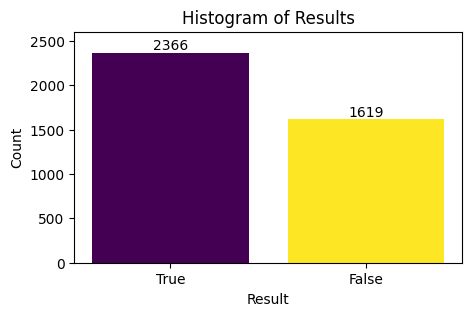

In [7]:
plt.figure(figsize=(5, 3))
colors = cmap(np.linspace(0, 1, len(counts)))

bars = plt.bar(counts.index.astype(str), counts.values, color=colors)

plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Histogram of Results")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha="center", va="bottom")
plt.ylim(0, max(counts.values) * 1.1)
plt.show()

In [8]:
counts = df["reason"].value_counts()

fig2 = px.bar(
        x=counts.index[:5],
        y=counts.values[:5],
        text=counts.values[:5],
        color=counts.values[:5],
        color_continuous_scale="viridis",
        labels={"x": "Reason", "y": "Count"},
        title="Top 5 reasons for all complaints",
    )

fig2.update_traces(text=counts.values, textposition="outside")
fig2.update_yaxes(range=[0, max(counts.values) * 1.2])
fig2.update_layout(bargap=0.5, width=720, height=400, coloraxis_showscale=False)
fig2.show()

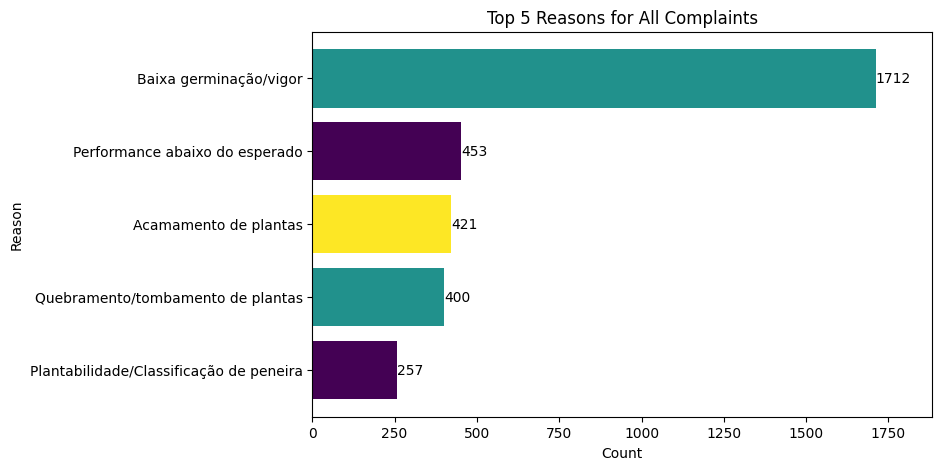

In [9]:
counts = counts.sort_values(ascending=True).tail(5)

plt.figure(figsize=(8, 5))
colors = cmap(np.linspace(0, 1, 3))

bars = plt.barh(counts.index, counts.values, color=colors)

plt.ylabel('Reason')
plt.xlabel('Count')
plt.title('Top 5 Reasons for All Complaints')


for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, int(bar.get_width()), va='center')

plt.xlim(0, max(counts.values) * 1.1)

plt.show()

In [10]:
bar1 = go.Bar(
    name="True",
    x=df[df["result"] == True]["reason"].value_counts().index[:1],
    y=df[df["result"] == True]["reason"].value_counts().values[:1],
    text=df[df["result"] == True]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#440154",
)

bar2 = go.Bar(
    name="False",
    x=df[df["result"] == False]["reason"].value_counts().index[:1],
    y=df[df["result"] == False]["reason"].value_counts().values[:1],
    text=df[df["result"] == False]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#31688e"
)

fig3 = go.Figure(data=[bar1, bar2])

fig3.update_layout(
    barmode="group",
    title_text="Top reason for complaints by result",
    bargap=0.5,
    width=600,
    height=400,
)

fig3.show()

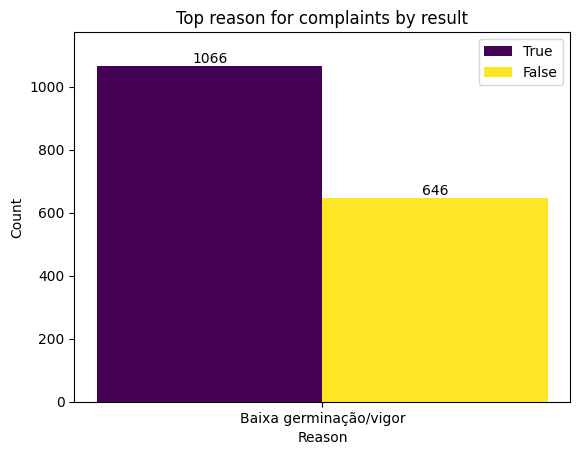

In [11]:
colors = cmap(np.linspace(0, 1, 2))

x1 = np.arange(1)  # x1 is now an array of indices
y1 = df[df["result"] == True]["reason"].value_counts().values[:1]
bars1 = plt.bar(x1, y1, color=colors[0], align='edge', width=-0.4)

x2 = np.arange(1)  # x2 is now an array of indices
y2 = df[df["result"] == False]["reason"].value_counts().values[:1]
bars2 = plt.bar(x2, y2, color=colors[1], align='edge', width=0.4)

plt.xlabel('Reason')
plt.ylabel('Count')
plt.title('Top reason for complaints by result')
plt.legend(['True', 'False'])

plt.xticks(x1, df[df["result"] == True]["reason"].value_counts().index[:1])

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')


plt.ylim(0, max(y1) * 1.1)

plt.show()

## Statistical tests
### Chi-Squared Test

The Chi-Squared Test of Independence is used to determine if there is a significant association between two categorical variables. The null hypothesis (H0) is that the variables are independent, and the alternative hypothesis (H1) is that the variables are dependent.

The formula is:
$$\chi^2 = \sum \frac {(O - E)^2}{E}$$

Where $O$ is the observed frequency and $E$ is the expected frequency.

In [108]:
# Pretty print
colors = {'PURPLE':'\033[95m', 'CYAN':'\033[96m', 'DARKCYAN':'\033[36m', 'BLUE':'\033[94m',
          'GREEN':'\033[92m', 'YELLOW':'\033[93m', 'RED':'\033[91m','BOLD':'\033[1m',
          'UNDERLINE':'\033[4m', 'END':'\033[0m'}

In [13]:
categorical_variables = constants.CATEGORICAL_COLUMNS
alpha = 0.05

for var in categorical_variables:
    contingency_table = pd.crosstab(df["result"], df[var])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print('Chi-Squared Test of Independence for variable -> ' + colors['UNDERLINE'] + var + colors['END'])
    print(colors['BOLD'] + 'p-value' + colors['END'] + ' = ' + str(p))
    if p <= alpha:
        print(colors['GREEN'] +"Dependent (reject H0)\n" + colors['END'])
    else:
        print(colors['RED'] +"Independent (H0 holds true)\n" + colors['END'])

Chi-Squared Test of Independence for variable -> plant
p-value = 3.4439898088286545e-27
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> storage
p-value = 3.179461176926628e-21
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> location
p-value = 1.0821698856832491e-63
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> treatment
p-value = 0.0001274017720288051
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> hybrid
p-value = 9.741533614237658e-79
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> reason
p-value = 1.8386698047731776e-23
Dependent (reject H0)



### Cramer's V
Cramer's V is a scaled version of the chi-squared test statistic $\chi^2$, which ranges from 0 to 1. It is used to measure the strength of association between two nominal variables. The value of Cramer's V ranges from 0 to 1, where 0 indicates no association between the variables, and 1 indicates a strong association between the variables.

The formula is:
$$Cramer's V = \sqrt{\chi^2/(n\cdot(k-1))}$$

Where $\chi^2$ is the chi-squared test statistic, $n$ is the number of observations, and $k$ is the number of categories in the contingency table.

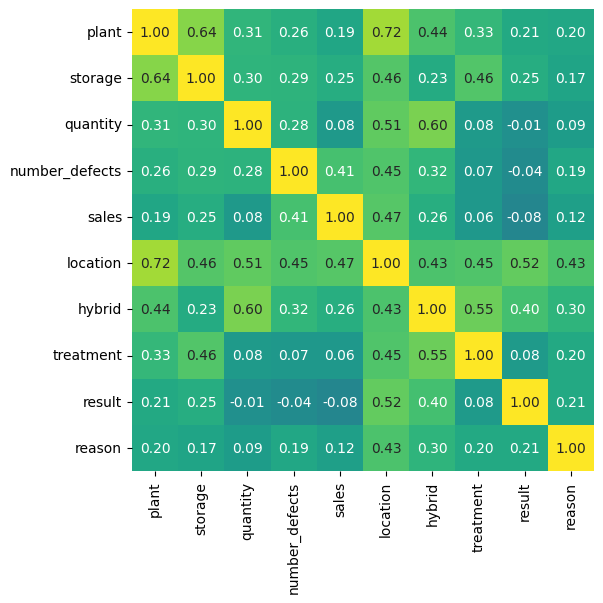

In [14]:
cramers_v = associations(df, figsize=(6, 6), cbar=False, cmap="viridis")

In [15]:
df_associations = pd.DataFrame(cramers_v["corr"])
sorted_associations = pd.DataFrame(
    df_associations["result"].sort_values(ascending=False)[1:6]
)

fig4 = px.bar(
    sorted_associations,
    y="result",
    x=sorted_associations.index,
    color="result",
    color_continuous_scale="viridis",
    title="Top 5 Ranked Associations with Result",
    labels={"index": "Variable", "result": "Cramér's V Score"},
)

fig4.update_yaxes(range=[0, max(sorted_associations["result"]) * 1.1])
fig4.update_traces(text=round(sorted_associations["result"], 3), textposition="outside")

fig4.show()

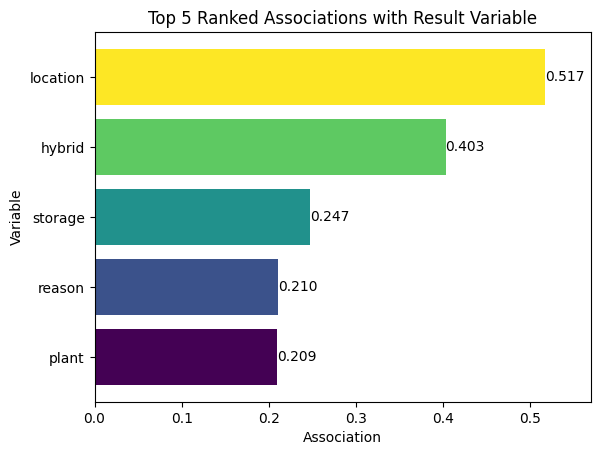

In [16]:
sorted_associations = sorted_associations.sort_values(by="result", ascending=True)

colors = cmap(np.linspace(0, 1, len(sorted_associations)))

bars = plt.barh(sorted_associations.index, sorted_associations["result"], color=colors)

plt.xlabel("Association")
plt.ylabel("Variable")
plt.title("Top 5 Ranked Associations with Result Variable")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left')
    

plt.xlim(0, max(sorted_associations["result"]) * 1.1)

plt.show()

## Model

### Splitting the data
The data is split into training and testing sets with a 80-20 ratio.

In [57]:
X = df.drop('result', axis=1)
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling numerical variables and encoding categorical variables
The numerical variables are scaled using the `StandardScaler` method from the `sklearn` library. The categorical variables are encoded using the `CountEncoder` method from the `category_encoders` library.

In [54]:
from sklearn.preprocessing import StandardScaler

In [58]:
encoder = ce.CountEncoder(cols=constants.CATEGORICAL_COLUMNS)
scaler = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

### LightGBM
LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed for speed and efficiency and can handle large datasets.

In [59]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

In [60]:
param_grid_lgbm = {
    'learning_rate': [0.05, 0.08, 0.1,],
    'max_depth': [3, 7, 15, 25, 30, 50],
    'num_leaves': [7, 15, 31, 63, 127, 255, 511],
    'n_estimators': [10, 50, 100, 200, 350]
}

In [61]:
lgbm_classifier = lightgbm.LGBMClassifier(random_state=42)

In [62]:
grid_search_lgbm = GridSearchCV(lgbm_classifier, param_grid_lgbm, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_lgbm.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[LightGBM] [Info] Number of positive: 1912, number of negative: 1276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 3188, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.599749 -> initscore=0.404420
[LightGBM] [Info] Start training from score 0.404420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.08, 0.1],
                         'max_depth': [3, 7, 15, 25, 30, 50],
                         'n_estimators': [10, 50, 100, 200, 350],
                         'num_leaves': [7, 15, 31, 63, 127, 255, 511]},
             scoring='roc_auc', verbose=1)

In [63]:
y_pred_lgbm = grid_search_lgbm.predict(X_test_scaled)

In [64]:
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"LGBM Accuracy: {accuracy_lgbm}")

LGBM Accuracy: 0.7590966122961104


In [65]:
print('Best hyperparameters:', grid_search_lgbm.best_params_)
print('Best AUC score:', grid_search_lgbm.best_score_)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 350, 'num_leaves': 127}
Best AUC score: 0.8174802195838436


In [66]:
y_pred_proba_lgbm = grid_search_lgbm.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lgbm)

fig5 = px.area(
    x=fpr, y=tpr,
    title=f"ROC Curve (AUC={grid_search_lgbm.best_score_})",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=600, height=400
)

fig5.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig5.show()

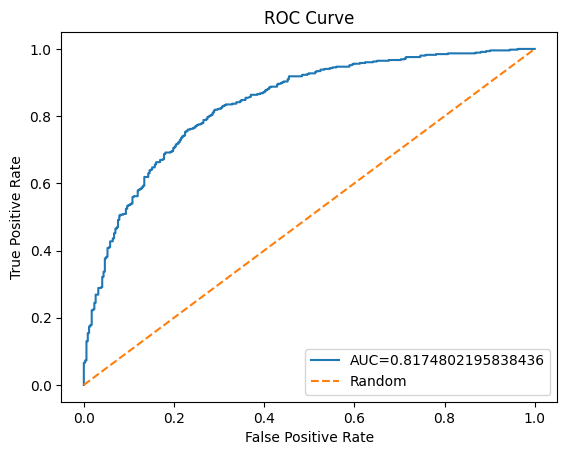

In [67]:
plt.plot(fpr, tpr, label=f"AUC={grid_search_lgbm.best_score_}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

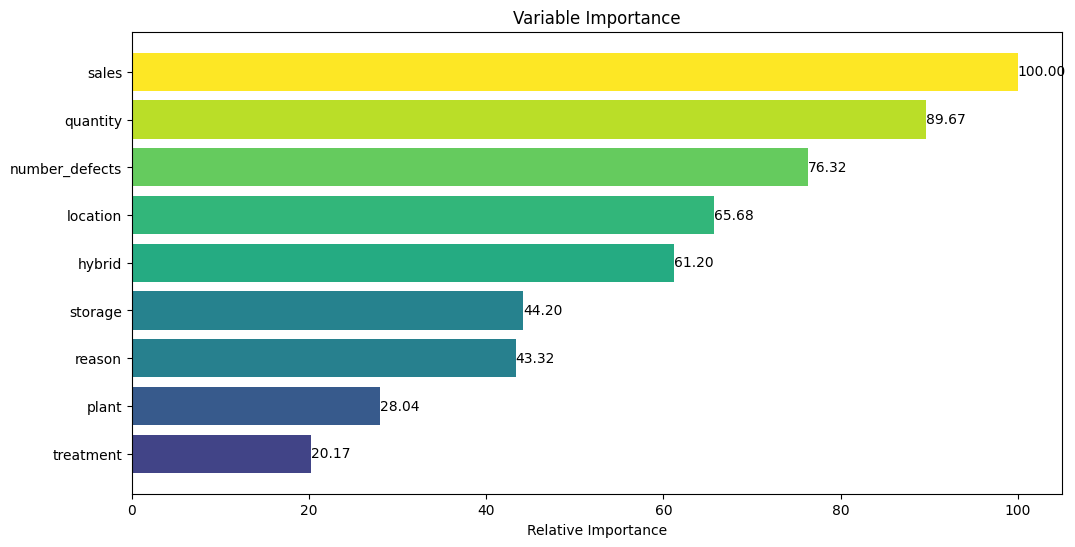

In [68]:
feature_importance = grid_search_lgbm.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
colors = cm.viridis(feature_importance[sorted_idx] / max(feature_importance[sorted_idx]))
bars = plt.barh(pos, feature_importance[sorted_idx], align='center', color=colors)
plt.yticks(pos, X_train_scaled.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             va='center', ha='left')
plt.show()

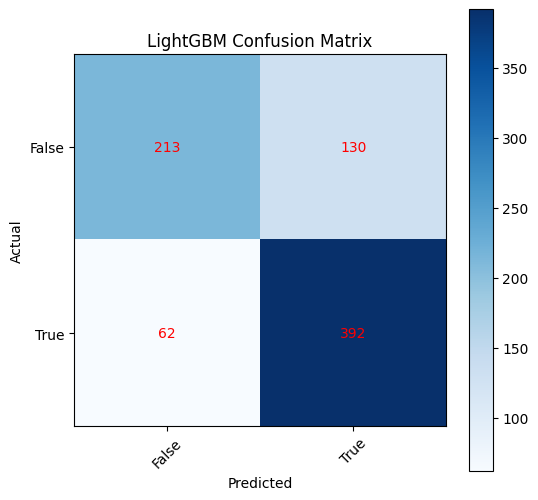

In [69]:
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['False', 'True'], rotation=45)
plt.yticks(tick_marks, ['False', 'True'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='red')

plt.title('LightGBM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier
Random Forest is an ensemble learning method that builds multiple decision trees and merges them together to get a more accurate and stable prediction.

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

In [71]:
param_grid_rfc = {
    'n_estimators': [5,10,25,50,75,100,150,200,500],
    'max_depth': [2, 10, 15, 20, 50],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [72]:
rfc = RandomForestClassifier(random_state=42)

In [73]:
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_rfc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 10, 15, 20, 50],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200,
                                          500]},
             scoring='roc_auc', verbose=1)

In [74]:
y_pred_rfc = grid_search_rfc.predict(X_test_scaled)

In [75]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f'Random Forest Accuracy: {accuracy_rfc}')

Random Forest Accuracy: 0.7854454203262233


In [76]:
print('Best hyperparameters:', grid_search_rfc.best_params_)
print('Best accuracy score:', grid_search_rfc.best_score_)

Best hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 500}
Best accuracy score: 0.835915214907739


In [77]:
# ROC AUC CURVE
y_pred_proba_rfc = grid_search_rfc.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rfc)

fig6 = px.area(
    x=fpr, y=tpr,
    title=f"ROC Curve (AUC={grid_search_rfc.best_score_})",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=600, height=400
)

fig6.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig6.show()

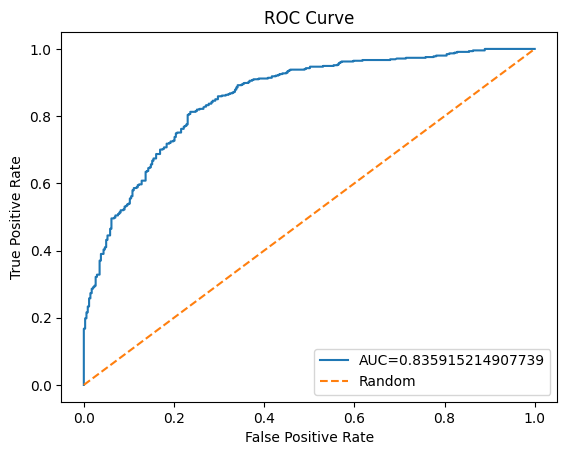

In [78]:
plt.plot(fpr, tpr, label=f"AUC={grid_search_rfc.best_score_}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

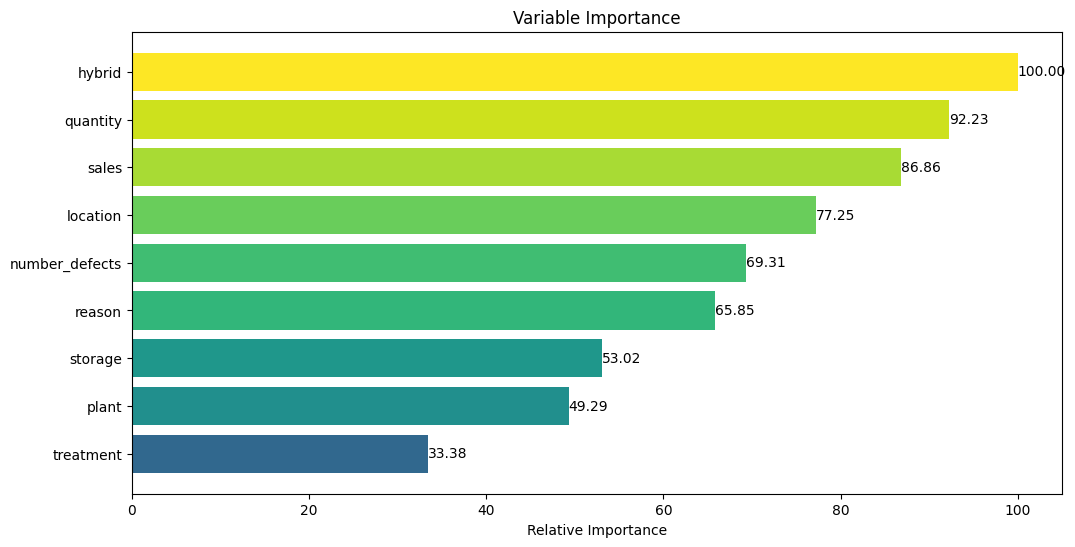

In [79]:
feature_importance = grid_search_rfc.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
colors = cm.viridis(feature_importance[sorted_idx] / max(feature_importance[sorted_idx]))
bars = plt.barh(pos, feature_importance[sorted_idx], align='center', color=colors)
plt.yticks(pos, X_train_scaled.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             va='center', ha='left')
plt.show()

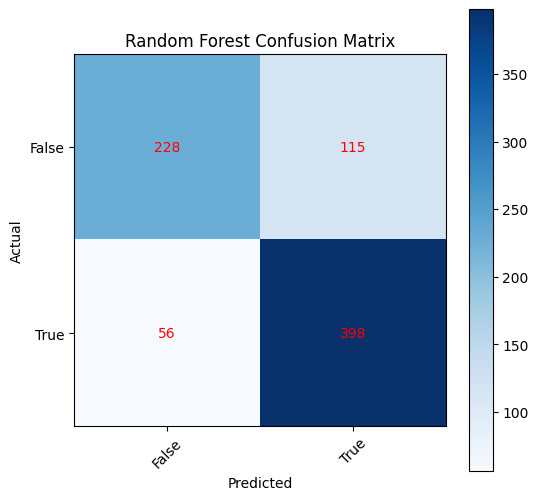

In [80]:
conf_matrix = confusion_matrix(y_test, y_pred_rfc)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['False', 'True'], rotation=45)
plt.yticks(tick_marks, ['False', 'True'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='red')

plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Results

In [110]:
# Results
print(colors['BOLD'] + colors['PURPLE'] + 'LightGBM' + colors['END'])
print(colors['BOLD'] + 'Accuracy:' + colors['END'], accuracy_lgbm)
print(colors['BOLD'] +'ROC AUC:' + colors['END'], grid_search_lgbm.best_score_)
print(colors['BOLD'] +'Best hyperparameters:' + colors['END'], grid_search_lgbm.best_params_)

print(colors['BOLD'] + colors['CYAN'] +'\nRandom Forest'+ colors['END'])
print(colors['BOLD'] + 'Accuracy:' + colors['END'], accuracy_rfc)
print(colors['BOLD'] + 'ROC AUC:' + colors['END'], grid_search_rfc.best_score_)
print(colors['BOLD'] + 'Best hyperparameters:' + colors['END'], grid_search_rfc.best_params_)

LightGBM
Accuracy: 0.7590966122961104
ROC AUC: 0.8174802195838436
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 350, 'num_leaves': 127}

Random Forest
Accuracy: 0.7854454203262233
ROC AUC: 0.835915214907739
Best hyperparameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 500}


In [111]:
fig7 = go.Figure()

fig7.add_trace(go.Bar(
    x=['LightGBM', 'Random Forest'],
    y=[accuracy_lgbm, accuracy_rfc],
    name='Accuracy',
    marker_color='#440154',
    text=[f'{accuracy_lgbm:.3f}', f'{accuracy_rfc:.3f}'],
    textposition='outside'
))

fig7.add_trace(go.Bar(
    x=['LightGBM', 'Random Forest'],
    y=[grid_search_lgbm.best_score_, grid_search_rfc.best_score_],
    name='ROC AUC',
    marker_color='#fde725',
    text=[f'{grid_search_lgbm.best_score_:.3f}', f'{grid_search_rfc.best_score_:.3f}'],
    textposition='outside'
))

max_y = max(accuracy_lgbm, accuracy_rfc, grid_search_lgbm.best_score_, grid_search_rfc.best_score_)

fig7.update_layout(
    barmode='group', 
    title='Model Comparison', 
    width=600, 
    height=400,
    yaxis=dict(
        range=[0, max_y + 0.1] 
    ),
)

fig7.show()

## Save the model
The model is saved using the `joblib` library.

In [112]:
import joblib

In [113]:
# Save the random forest model
joblib.dump(grid_search_rfc, 'models/rfc-model.pkl')

['models/rfc-model.pkl']